#IR spectral analysis of organic and coordination compounds via machine learning and neural networks
By: Koshelev Daniil 

-Work in progress (last updated:10/06/2023)-

B. Цель данного блокнота

Целью этого блокнота является создание датасета на 72 класса и обучение модели на классификацию 72 классов.

C. План реализации

1. Импортировать данные
2. Реализовать приписывание 92 классов через правильные SMARTs ключи
3. Создать класс датасета
4. Создать и обучить модель
5. Собрать статистику

NOTES
1. Импортированы данные
2. Создаётся слварь SMARTs ключей
3. Оттестированы модели с 50 и 72 кратными картами признаков
4. Протестирована модель с дополнительным слоем проявления полос. 


Клонирование данных с GitHub. На сайте выложены как исходные списки веществ, так и скачанные спектры соединений, которые были запарсены кодом ниже.

In [1]:
!git clone https://github.com/Lamblador/IR_expert_system.git

Cloning into 'IR_expert_system'...
remote: Enumerating objects: 17276, done.
remote: Counting objects: 100% (2433/2433), done.
remote: Compressing objects: 100% (2272/2272), done.
remote: Total 17276 (delta 179), reused 2397 (delta 157), pack-reused 14843
Receiving objects: 100% (17276/17276), 1.47 GiB | 30.09 MiB/s, done.
Resolving deltas: 100% (539/539), done.
Updating files: 100% (16977/16977), done.


In [2]:
from IPython.core.display import clear_output
!pip install --upgrade jcamp
!pip install cirpy
!pip install peakutils
!pip install datamol
!pip install rdkit
clear_output()

In [3]:
# Вводятся нужные импорты
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob
import os
import numpy as np
import torch
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision import datasets
import torch.nn as nn
from peakutils.peak import indexes as index_utils


In [4]:
import random

import torch
import torch.nn as nn
from torchvision import datasets, transforms


def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_random_seed(42)

# Импорт табличных данных

In [5]:
#Считывание датасета
def read_dataset(dataset_name):
  '''
  Function for reading dataset into pandas Dataframe from /IR_expert_system/data/datasets/

  dataset_name - name of dataset's folder to read

  return pd.Dataframe with whole dataset

  parameters:
      name = ['dataset3']
          dataset3 - dataset made from reading most of jcam files, with padded y, interpolated x and peak layer. Saved in 10 pieces. 
  '''
  df_list = []
  # choose current directory
  curr_directory = os.getcwd()
  os.chdir(curr_directory)  # set to current directory
  files = glob.glob('/content/IR_expert_system/data/datasets/'+dataset_name+'/*.pkl')  # look for files without extension. Returns a list.
  # Try to read the file. If can't be read, skip it.
  print(files)
  for i, file in tqdm(enumerate(files)):
      df = pd.read_pickle(file)
      df_list.append(df)
  #print(df_list)
  result = pd.concat(df_list)
  return result

dataset_df = read_dataset('dataset3')
dataset_df

['/content/IR_expert_system/data/datasets/dataset3/nist_ir_spectra_dataset3_1.pkl', '/content/IR_expert_system/data/datasets/dataset3/nist_ir_spectra_dataset3_2.pkl', '/content/IR_expert_system/data/datasets/dataset3/nist_ir_spectra_dataset3_0.pkl', '/content/IR_expert_system/data/datasets/dataset3/nist_ir_spectra_dataset3_5.pkl', '/content/IR_expert_system/data/datasets/dataset3/nist_ir_spectra_dataset3_4.pkl', '/content/IR_expert_system/data/datasets/dataset3/nist_ir_spectra_dataset3_9.pkl', '/content/IR_expert_system/data/datasets/dataset3/nist_ir_spectra_dataset3_8.pkl', '/content/IR_expert_system/data/datasets/dataset3/nist_ir_spectra_dataset3_3.pkl', '/content/IR_expert_system/data/datasets/dataset3/nist_ir_spectra_dataset3_6.pkl', '/content/IR_expert_system/data/datasets/dataset3/nist_ir_spectra_dataset3_7.pkl']


10it [00:04,  2.44it/s]


,index,title,jcamp-dx,data type,origin,owner,molform,$nist source,spectrometer/data system,state,...,number of interferograms averaged per single channel spectrum,sample description,temperature,$spectra version,$uncertainty in y,pressure,x1,y1,y_peak,x_peak
cas registry no,,,,,,,,,,,,,,,,,,,,,
7496-45-9,7496-45-9,"Purine, 1-ethyl-",4.24,INFRARED SPECTRUM,SOUTHERN RESEARCH INSTITUTE,Copyright (C) 1987 by the Coblentz Society\nCo...,C7 H8 N4,COBLENTZ,PERKIN-ELMER 221 (GRATING),SOLID (0.8 mg / 650 mg KBr DISC),...,NaN,NaN,NaN,NaN,NaN,NaN,"[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.13739997148513794, 0.13739997148513794, 0.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[580, 640, 664, 726, 798, 834, 928, 966, 1022,..."
106-36-5,106-36-5,"Propanoic acid, propyl ester",4.24,INFRARED SPECTRUM,Sadtler Research Labs Under US-EPA Contract,NIST Standard Reference Data Program\nCollecti...,C 6 H 12 O 2,MSDC-IR,NaN,gas,...,NaN,NaN,NaN,NaN,NaN,NaN,"[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.05554400011897087, 0.054496001452207565, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[542, 594, 618, 642, 674, 770, 814, 838, 882, ..."
5347-82-0,5347-82-0,DIMETHANE SULFONAMIDE,4.24,INFRARED SPECTRUM,"WYANDOTTE CHEMICALS CORP., WYANDOTTE, MICHIGAN...",COBLENTZ SOCIETY\nCollection (C) 2018 copyrigh...,C2 H7 N O4 S2,COBLENTZ,"Not specified, most likely a prism, grating, o...",SOLID (MULL),...,NaN,NaN,NaN,NaN,NaN,NaN,"[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.21799999475479126, 0.21799999475479126, 0.2...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[632, 662, 766, 866, 974, 1024, 1066, 1150, 13..."
112-17-4,112-17-4,1-Decanol acetate,4.24,INFRARED SPECTRUM,NIST Mass Spectrometry Data Center,NIST Standard Reference Data Program\nCollecti...,C 12 H 24 O 2,MSDC-IR,HP-GC/MS/IRD,gas,...,NaN,NaN,NaN,NaN,NaN,NaN,"[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.0001320000010309741, 0.0001320000010309741,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1042, 1234, 1370, 1462, 1762, 2866, 2934]"
4919-37-3,4919-37-3,"4-Hydroxy-3,5-dimethylbenzoic acid",4.24,INFRARED SPECTRUM,EPA-IR VAPOR PHASE LIBRARY,SRD/NIST\nCollection (C) 2018 copyright by the...,C 9 H 10 O 3,MSDC-IR,NaN,gas,...,NaN,NaN,NaN,NaN,NaN,NaN,"[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.01228999998420477, 0.01228999998420477, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[588, 656, 770, 934, 1104, 1146, 1198, 1266, 1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25173-72-2,25173-72-2,"3-(3,4,5-Trimethoxyphenyl)propionic acid",4.24,INFRARED SPECTRUM,EPA-IR VAPOR PHASE LIBRARY,SRD/NIST\nCollection (C) 2018 copyright by the...,C 12 H 16 O 5,MSDC-IR,NaN,gas,...,NaN,NaN,NaN,NaN,NaN,NaN,"[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.010820000432431698, 0.010820000432431698, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[576, 778, 832, 930, 1016, 1044, 1118, 1186, 1..."
56946-83-9,56946-83-9,"2,5-Dichlorothiophene-3-sulphonyl chloride",4.24,INFRARED SPECTRUM,EPA-IR VAPOR PHASE LIBRARY,SRD/NIST\nCollection (C) 2018 copyright by the...,C 4 H Cl 3 O 2 S 2,MSDC-IR,NaN,gas,...,NaN,NaN,NaN,NaN,NaN,NaN,"[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.13794000446796417, 0.13794000446796417, 0.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[558, 598, 632, 830, 854, 1008, 1046, 1136, 11..."
823-09-6,823-09-6,"Pyrimidine, 2-(methylthio)-,",4.24,INFRARED SPECTRUM,SOUTHERN RESEARCH INSTITUTE,Copyright (C) 1987 by the Coblentz Society\nCo...,C5 H6 N2 S,COBLENTZ,PERKIN-ELMER 21 (GRATING),LIQUID (NEAT),...,NaN,NaN,NaN,NaN,NaN,NaN,"[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.2558000087738037, 0.2558000087738037, 0.255...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[610, 710, 748, 770, 796, 876, 964, 1012, 1062..."


In [6]:
labels_df = pd.read_csv('/content/IR_expert_system/data/nist_ir_spectra_list_with_72_bonds.csv')
labels_df = labels_df.set_index("CAS")

In [7]:
dataset72_df_labeled = labels_df.join(dataset_df)

In [8]:
dataset72_df_labeled1 = dataset72_df_labeled[[
 'Name',
 #'Formula',
 #'Mw',
 #'Elements',
 'InChi',
 #'SMILES',
 'C─H alkyl methyl 1260 strong/1380 weak/2870 medium to strong/2960 medium to strong',
 'C─H alkyl methylene 1470 strong/2850 medium to strong/2925 medium to strong',
 'C─H alkyl methine 2890 weak',
 'C─H vinyl C═CH2 900 strong/2975 medium/3080 medium',
 'C─H vinyl C═CH 3020 medium',
 'C─H vinyl monosubstituted alkenes 900 strong/990 strong',
 'C─H vinyl cis-disubstituted alkenes 670–700 strong',
 'C─H vinyl trans-disubstituted alkenes 965 strong',
 'C─H vinyl trisubstituted alkenes 800–840 strong to medium',
 'C─H aromatic benzene/sub. benzene 3070 weak',
 'C─H aromatic monosubstituted benzene 700–750 strong',
 'C─H aromatic monosubstituted benzene 690–710 strong',
 'C─H aromatic ortho-disub. benzene 750 strong',
 'C─H aromatic meta-disub. benzene 750–800 strong',
 'C─H aromatic meta-disub. benzene 860–900 strong',
 'C─H aromatic para-disub. benzene 800–860 strong',
 'C─H alkynes any 3300 medium',
 'C─H aldehydes any 2720 medium',
 'C─H aldehydes any 2820 medium',
 'C═C acyclic C═C monosub. alkenes 1645 medium',
 'C═C acyclic C═C 1,1-disub. alkenes 1655 medium',
 'C═C acyclic C═C cis-1,2-disub. alkenes 1660 medium',
 'C═C acyclic C═C trans-1,2-disub. alkenes 1675 medium',
 'C═C acyclic C═C trisub., tetrasub. alkenes 1670 weak',
 'C═C conjugated C═C dienes 1600 strong/1650 strong',
 'C═C with benzene ring dienes 1625 strong',
 'C═C with C═O dienes 1600 strong',
 'C═C C═C (both sp2) any 1640–1680 medium',
 'C═C aromatic C═C any 1450/1500/1580/1600 weak to strong (usually 3 or 4)',
 'C═C C≡C terminal alkynes 2100–2140 weak',
 'C═C C≡C disubst. alkynes 2190–2260 very weak (often indistinguishable)',
 'C=O aldehyde/ketone saturated aliph./cyclic 6-membered 1720 ',
 'C=O aldehyde/ketone α,β-unsaturated 1685 ',
 'C=O aldehyde/ketone aromatic ketones 1685 ',
 'C=O aldehyde/ketone aldehydes 1725 influenced by conjugation (as with ketones)',
 'C=O carboxylic acids/derivates saturated carboxylic acids 1710 ',
 'C=O carboxylic acids/derivates unsat./aromatic carb. acids 1680–1690 ',
 'C=O carboxylic acids/derivates esters and lactones 1735 influenced by conjugation and ring size (as with ketones)',
 'C=O carboxylic acids/derivates anhydrides 1760 ',
 'C=O carboxylic acids/derivates anhydrides 1820 ',
 'C=O carboxylic acids/derivates acyl halides 1800 ',
 'C=O carboxylic acids/derivates amides 1650 associated amides',
 'C=O carboxylic acids/derivates amino acid zwitterions 1550–1610 ',
 'O─H alcohols, phenols low concentration 3610–3670/high concentration 3200–3400 broad',
 'O─H carboxylic acids low concentration 3500–3560/high concentration 3000 broad',
 'N─H primary amines any 3400–3500 strong/1560–1640 strong',
 'N─H secondary amines any > 3000 weak to medium',
 'N─H ammonium ions any 2400–3200 multiple broad peaks',
 'C─O alcohols primary 1040–1060 strong, broad',
 'C─O alcohols secondary ~ 1100 strong',
 'C─O alcohols tertiary 1150–1200 medium',
 'C─O phenols any 1200',
 'C─O ethers aliphatic 1120',
 'C─O ethers aromatic 1220–1260',
 'C─O carboxylic acids any 1250–1300',
 'C─O esters any 1100–1300 two bands (distinct from ketones, which do not possess a C─O bond)',
 'C─N aliphatic amines any 1020–1220 often overlapped',
 'C─N C═N any 1615–1700 similar conjugation effects to C═O',
 'C─N C≡N (nitriles) unconjugated 2250 medium',
 'C─N C≡N (nitriles) conjugated 2230 medium',
 'C─N R─N─C (isocyanides) any 2165–2110',
 'C─N R─N═C═S (isothiocyanates) any 2140–1990',
 'C─X fluoroalkanes ordinary 1000–1100',
 'C─X fluoroalkanes trifluoromethyl 1100–1200 two strong, broad bands',
 'C─X chloroalkanes any 540–760 weak to medium',
 'C─X bromoalkanes any 500–600 medium to strong',
 'C─X iodoalkanes any 500 medium to strong',
 'N─O nitro compounds aliphatic 1540 stronger/aliphatic 1380 weaker',
 'N─O nitro compounds aromatic 1520 lower/1350 lower if conjugated',
 'P─C Organophosphorus compound aromatic 1440-1460 medium',
 'P─O phosphorus oxide bonded 1195-1250 strong',
 'P─O phosphorus oxide free 1250-1300 strong',
#  'index',
#  'title',
#  'jcamp-dx',
#  'data type',
#  'class',
#  'origin',
#  'owner',
#  'date',
#  'names',
#  'molform',
#  'source reference',
#  '$nist source',
#  '$nist image',
#  'spectrometer/data system',
#  'path length',
#  'sampling procedure',
#  'resolution',
#  'data processing',
#  'xunits',
#  'yunits',
#  'xfactor',
#  'yfactor',
#  'deltax',
#  'firstx',
#  'lastx',
#  'firsty',
#  'maxx',
#  'minx',
#  'maxy',
#  'miny',
#  'npoints',
#  'xydata',
#  'end',
 'x',
 'y',
#  'filename',
#  'state',
#  'instrument parameters',
#  'xlabel',
#  'ylabel',
#  'mp',
#  'bp',
#  '$nist doc file',
#  '$nist psd file',
#  'aperture',
#  'external diffuse reflectance accessory',
#  'beamsplitter',
#  'detector (dia. det. port in sphere)',
#  'sphere diameter',
#  'acquisition mode',
#  'scanner speed',
#  'coadded scans',
#  'phase resolution',
#  'phase correction',
#  'zerofilling',
#  'spectral range',
#  'spectral resolution',
#  'wavenumber accuracy',
#  'apodization function',
#  'low pass filter',
#  'switch gain on',
#'cas name',
#  'instrument resolution',
#  'ir source',
#  'detector',
#  'interferogram zerofill',
#  'spectral interval after zerofilling',
#  'apodization',
#  'folding limits',
#  'number of interferograms averaged per single channel spectrum',
#  '$spectra version',
#  '$uncertainty in y',
#  'sample description',
#  'pressure',
#  'temperature',
 'x1',
 'y1',
 'y_peak',
 'x_peak']]

In [9]:
#Список полос колебаний
all_num_list = [
[1260,1380,2870,2960],
[1470,2850,2925],
[2890],
[2900,2975,3080],
[3020],
[900,990],
[670,700],
[965],
[800,840],
[3070],
[700,750],
[690,710],
[750],
[750,800],
[860,900],
[800,860],
[3300],
[2720],
[2820],
[1645],
[1655],
[1660],
[1675],
[1670],
[1600,1650],
[1625],
[1600],
[1640,1680],
[1450,1500,1580,1600],
[2100,2140],
[2190,2260],
[1720],
[1685],
[1685],
[1725],
[1710],
[1680,1690],
[1735],
[1760],
[1820],
[1800],
[1650],
[1550,1610],
[3610,3670, 3200,3400],
[3500,3560, 3000],
[3400,3500, 1560,1640],
[3000],
[2400,3200],
[1040,1060],
[1100],
[1150,1200],
[1200],
[1120],
[1220,1260],
[1250,1300],
[1100,1300],
[1020,1220],
[1615,1700],
[2250],
[2230],
[2165,2110],
[2140,1990],
[1000,1100],
[1100,1200],
[540,760],
[500,600],
[500],
[1540,1380],
[1520,1350],
[1440,1460],
[1195,1250],
[1250,1300],
]

In [10]:
#Проверка чётности полосы
for i, num_list in enumerate(all_num_list):
  for j, num in enumerate(num_list):
    if num%2 == 1: all_num_list[i][j]=all_num_list[i][j]+1
#all_num_list

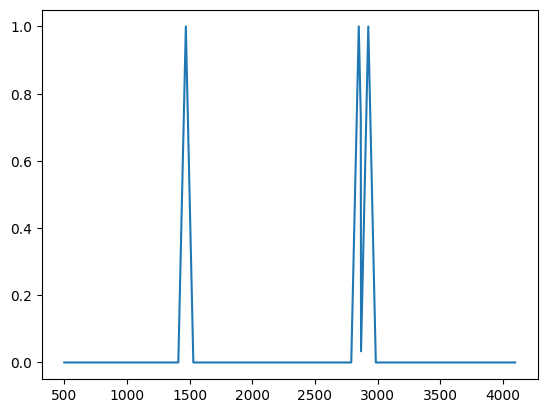

In [11]:
#Создаём дополнительный слой для каждого класса для входа в сеть, где +/- вокруг предполагаемого положения будет от 0 до 1, а вне - 0.
def print_peak_neighborhood(peak_indx, x, num_neighbors = 10):
  '''
  Cover neighbor of the class peak position with numbers between 0 and 1

  parameters:
  peak_indx - list of even wavenumber (1/cm) of peak possible position
  x - array like object of wavenumbers in spectra
  num_neighbors - nuber of neighbors which should be changed. Means the area of intrest of NN.
  '''
  class_peak_indx_list = []
  for num in peak_indx:
      try:
        y_mask_4_class = np.zeros(len(x))
        class_peak_indx_list.append(list(x).index(num))
      except TypeError:
        y_mask_4_class = np.zeros(1800)
        continue
  for i in class_peak_indx_list:
      for k in range(num_neighbors):
          y_mask_4_class[i-k] = 1-(1/num_neighbors)*k
          y_mask_4_class[i+k] = 1-(1/num_neighbors)*k
  return y_mask_4_class
#Проверка работоспособности
plt.plot(dataset72_df_labeled1.iloc[:,-4][1], print_peak_neighborhood(all_num_list[1], dataset72_df_labeled1.iloc[:,-4][1], num_neighbors = 30))

In [12]:
dataset72_df_labeled1.iloc[:,-4][1]

array([ 500,  502,  504, ..., 4094, 4096, 4098])

In [13]:
#Создаём дополнительный слой для каждого класса для входа в сеть, где +/- вокруг предполагаемого положения будет от 0 до 1, а вне - 0.
df_cls_attention = []
for i, num_list in enumerate(all_num_list):
  class_attention = print_peak_neighborhood(all_num_list[i], dataset72_df_labeled1.iloc[:,-4][i], num_neighbors = 30)
  df_cls_attention.append(torch.Tensor(class_attention))
#print(df_cls_attention)
df_cls_attention = torch.stack(df_cls_attention, dim=1).reshape((1800,72))
df_cls_attention.size()

torch.Size([1800, 72])

In [14]:
#Схлопываем все слои в один
df_cls_attention = torch.sum(df_cls_attention, dim=1)

In [15]:
#нормирование слоя на 1
df_cls_attention = df_cls_attention/max(df_cls_attention)

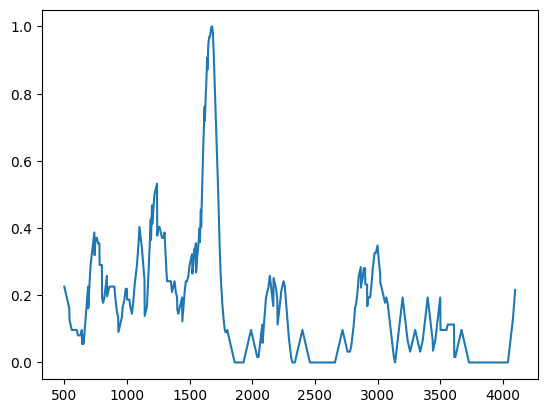

In [16]:
plt.plot(dataset72_df_labeled1.iloc[:,-4][1], df_cls_attention)

# Создание класса Dataset

In [17]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision import datasets

class IRSpectraDataset72(Dataset):
    def __init__(self, dataset_df_labeled): #, df_cls_attention
        self.dataset_df = dataset_df_labeled
        #self.df_cls_attention = df_cls_attention
        self.spectra_labels = self.dataset_df.iloc[:,2:-6]
        self.spectra_x = self.dataset_df.iloc[:,-4]
        self.spectra_y = self.dataset_df.iloc[:,-3]
        self.spectra_y_peak = self.dataset_df.iloc[:,-2]
        
    def __len__(self):
        return len(self.dataset_df)

    def __getitem__(self, idx):
        
        spectra_x = torch.Tensor(self.spectra_x.iloc[idx]).reshape((1, 1800))
        spectra_y = torch.Tensor(self.spectra_y.iloc[idx]).reshape((1, 1800)) 
        #class_attention = torch.Tensor(self.df_cls_attention).reshape((1, 1800))
        spectra_y_peak = torch.Tensor(self.spectra_y_peak.iloc[idx]).reshape((1, 1800))     
        spectra = torch.cat((spectra_x, spectra_y, spectra_y_peak)) #, df_cls_attention
        
        label = torch.Tensor(self.spectra_labels.iloc[idx])
        #transform
        return spectra, label

In [18]:
dataset_ir_spectra = IRSpectraDataset72(dataset72_df_labeled1) #, df_cls_attention

In [19]:
#Создание объекта класса и разбиение на трейн,тест и вал
from torch.utils.data import random_split
dataset_ir_spectra = IRSpectraDataset72(dataset72_df_labeled1.dropna()) #, df_cls_attention
train_size = int(0.7 * len(dataset_ir_spectra))
val_size = int(0.1 * len(dataset_ir_spectra))
test_size = len(dataset_ir_spectra) - train_size - val_size
train_dataset, test_dataset = random_split(dataset_ir_spectra, [train_size, int(test_size+val_size)])
test_dataset, val_dataset = random_split(test_dataset, [test_size, val_size])

In [20]:
#Создание загрузчиков
# Number of classes
classes = list(dataset_ir_spectra.spectra_labels.columns)
num_classes = len(classes)
num_classes

72

In [21]:
cls2inx = {}
inx2cls= {}
for i, classs in enumerate(classes):
  cls2inx[f'{classs}']= i
  inx2cls[i] = classs
#print(cls2inx)
#print(inx2cls)

In [22]:
# Расчёт весов
wts4cls = {}
for classs in classes:
  wts4cls[classs] = dataset_ir_spectra.spectra_labels[classs].mean()
#print(wts4cls)

In [23]:
#Веса классов
wts_list = []
for name, values in wts4cls.items():
  wts_list.append(values)
weight_for_every_class = torch.tensor(wts_list)
print(weight_for_every_class)

tensor([0.6218, 0.5915, 0.2465, 0.0503, 0.1127, 0.0351, 0.0361, 0.0361, 0.0349,
        0.5688, 0.1353, 0.1353, 0.1042, 0.0349, 0.0349, 0.1047, 0.0085, 0.0267,
        0.0267, 0.0351, 0.0503, 0.0902, 0.0902, 0.0610, 0.0099, 0.0484, 0.0425,
        0.1357, 0.5807, 0.0085, 0.0112, 0.1924, 0.0188, 0.1371, 0.0206, 0.0602,
        0.0266, 0.1192, 0.0040, 0.0040, 0.0096, 0.0709, 0.0028, 0.0714, 0.0603,
        0.1019, 0.1094, 0.0047, 0.0498, 0.0477, 0.0187, 0.0714, 0.0434, 0.0055,
        0.0603, 0.1164, 0.1927, 0.0406, 0.0383, 0.0027, 0.0400, 0.0157, 0.0377,
        0.0305, 0.0519, 0.0256, 0.0037, 0.0035, 0.0540, 0.0067, 0.0164, 0.0170],
       dtype=torch.float64)


In [24]:
# #Модифицирование весов для каждого класс:
# level = 0.3
# grain = 0.15
# lg = level/grain
# print(lg)
# #Классы меньше grain процентов - увеличиваются в level/20 раза 
# #Классы меньше 10 процентов - увеличиваются в level/10 раз 
# #Классы меньше 5 процентов - увеличиваются в level/5 раз
# #Классы меньше 1 процента - увеличиваются в level раз
# weight_for_every_class_modified = []
# for i in weight_for_every_class:
#   if i <= grain/8: weight_for_every_class_modified.append(i/(32/lg))
#   elif (i <= grain/4) and (i>grain/8): weight_for_every_class_modified.append(i/(16/lg))
#   elif (i <= grain/2) and (i>grain/4): weight_for_every_class_modified.append(i/(8/lg))
#   elif (i <= grain) and (i>grain/2): weight_for_every_class_modified.append(i/(4*lg))
#   else: weight_for_every_class_modified.append(i)
# weight_for_every_class_modified = torch.Tensor(weight_for_every_class_modified)
# print(weight_for_every_class)
# print(weight_for_every_class_modified)
# print(weight_for_every_class_modified.size())

In [25]:
#Расчёт веса образца на основе минимального веса любой функциональной группы 
labels1 = train_dataset.dataset.spectra_labels.to_numpy().copy()
labels1[labels1 == 0.0] = 100
#labels1

In [26]:
train_labels = torch.tensor(labels1)
weighted_labels  = train_labels*weight_for_every_class
weights_for_every_sample = []
for label_tensor in weighted_labels:
  weight = np.nanmin(label_tensor.numpy())
  weights_for_every_sample.append(weight)

weights_for_every_sample = torch.tensor(weights_for_every_sample)
print(weights_for_every_sample)

tensor([0.0540, 0.0540, 0.0540,  ..., 0.0519, 0.0540, 0.1094],
       dtype=torch.float64)


In [27]:
weights_train = weights_for_every_sample[:len(train_dataset)]

In [28]:
weights_train

tensor([0.0540, 0.0540, 0.0540,  ..., 0.0256, 0.0477, 0.0519],
       dtype=torch.float64)

In [29]:
#Проверка на положительные вероятности
for i in range(len(weights_train)):
    if weights_train[i] < 0:
        weights_train[i] = abs(weights_train[i])

In [30]:
weights_train[weights_train<0]

tensor([], dtype=torch.float64)

In [31]:
#Сумма весов должна быть равна единице. Вычисление суммы:
sum_weights = 0
for i in range(len(weights_train)):
 
  #print(weights_train[i])
  if weights_train[i] == torch.tensor(np.nan, dtype=torch.float64) : weights_train[i] = 1
  #print(weights_train[i])
  #print(sum_weights)
  sum_weights +=weights_train[i].numpy()
print(sum_weights)

676.911948095711


In [32]:
#Сумма весов должна быть равна единице. Нормирование на сумму.
for i in range(len(weights_train)):
    weights_train[i] =  weights_train[i]/sum_weights

In [33]:
weights_train = weight_for_every_class

In [34]:
#Даталоадер

from torch.utils.data import DataLoader, WeightedRandomSampler

# Batch size
batch_size = 128

dataloader_ir_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dataloader_ir_val = DataLoader(val_dataset, batch_size=val_size, shuffle=False)
weightedsampler = WeightedRandomSampler(weights_train, len(weights_train)) 

dataloader_ir_train = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    #sampler= weightedsampler
)

In [35]:
#Даталоадер для статистики

# Batch size
batch_size = 128
dataloader_ir_stat = DataLoader(dataset_ir_spectra, batch_size=batch_size, shuffle=False)

# Код для обучения

Взят из https://github.com/Gan4x4/ml_snippets/blob/main/Training/Trainer.ipynb

In [36]:
import torch
from tqdm import tqdm
from sklearn.metrics import label_ranking_average_precision_score


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def get_correct_count(pred, labels, tolerance = 0.9):
    pred.data[pred.data >=tolerance] = 1
    pred.data[pred.data <tolerance] = -1
    return (pred.data.cpu() == labels.cpu()).sum().item()

def get_correct_count_lraps(pred, labels):
    return label_ranking_average_precision_score(labels, pred.cpu().detach().numpy())
    


@torch.inference_mode()  # this annotation disable grad computation
def validate(model, test_loader, device="cpu", criterion = nn.BCELoss()):
    correct, total = 0, 0
    model.eval()
    for ir_spec, labels in test_loader:
      
        pred = model(ir_spec.to(device))
        loss = criterion(pred, labels.to(device))
        score= get_correct_count_lraps(pred, labels)
    return score, loss

In [37]:
class Trainer:
    def __init__(self, model, plotter=None, lr=0.001):
        global device
        print("Using device:", device)
        self.model = model
        self.optimizer = torch.optim.AdamW(
            self.model.parameters(), lr=lr
        )  
        self.sheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size = 75, gamma=0.2, last_epoch=- 1, verbose=True)
        self.criterion = nn.BCEWithLogitsLoss(pos_weight = weight_for_every_class.to(device))  # Loss function
        self.plotter = ProgressPlotter() if plotter is None else plotter
        self.epochs = 2
        self.loss_hist = []
        self.loss_hist_tst = []

    def __call__(self, train_loader, val_loader, epochs=10):
        global device
        print("Using device:", device)
        self.epochs = epochs
        self.model.to(device)
        
        for epoch in tqdm(range(self.epochs)):
            self.model.train()
            self.loss_hist = []
            self.loss_hist_tst = []
            correct, total = 0, 0
            for ir_spec, labels in train_loader:
                
                score = self.process_batch(ir_spec, labels)
            self.sheduler.step()
            self.plotter.add_scalar("Loss/train", np.mean(self.loss_hist))
            label_ranking_average_precision_score_val, val_loss = validate(self.model, val_loader, device=device, criterion=self.criterion)
            self.loss_hist_tst.append(val_loss.cpu())
            self.plotter.add_scalar("label_ranking_average_precision_score/val", label_ranking_average_precision_score_val)
            self.plotter.add_scalar("Loss/val", np.mean(self.loss_hist_tst))
            #self.plotter.add_scalar("label_ranking_average_precision_score/train", correct / total)
            self.plotter.display(["Loss/train", "Loss/val", "label_ranking_average_precision_score/val"])
          

    def process_batch(self, ir_spec, labels):
        self.optimizer.zero_grad()
        out = self.model(ir_spec.to(device))
        loss = self.criterion(out, labels.to(device))
        loss.backward()
        self.loss_hist.append(loss.item())
        self.optimizer.step()
        
        return get_correct_count_lraps(out.cpu(), labels)

In [38]:
from IPython.display import clear_output
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np


class ProgressPlotter:
    def __init__(self, title="default", groups=None) -> None:
        self._history_dict = defaultdict(dict)
        self.set_title(title)
        self.groups = self.get_groups(groups)

    def get_groups(self, groups):
        if groups is not None:
            return self._history_dict.keys()
        if type(groups) is str:
            groups = [groups]
        return groups

    def set_title(self, title):
        for g in self._history_dict.keys():
            self._history_dict[g][title] = []  # reset data
        self.title = title

    # group e.g. "loss_val" tag e.g. "experiment_1"
    def add_scalar(self, group: str, value, tag=None) -> None:
        tag = self.title if tag is None else tag

        if not tag in self._history_dict[group]:
            self._history_dict[group][tag] = []
        self._history_dict[group][tag].append(value)

    def add_row(self, group: str, value, tag=None) -> None:
        tag = self.title if tag is None else tag
        self._history_dict[group][tag] = value

    def display_keys(self, ax, data):
        history_len = 0
        ax.grid()
        for key in data:
            ax.plot(data[key], label=key)
            history_len = max(history_len, len(data[key]))
        if len(data) > 1:
            ax.legend(loc="upper right")
        if history_len < 50:
            ax.set_xlabel("step")
            ax.set_xticks(np.arange(history_len))
            ax.set_xticklabels(np.arange(history_len))

    """
     groups list of keys like [['loss_train','loss_val'],['accuracy']]
     All charts within a group will be plot in the same axis
  """

    def display(self, groups=None):
        clear_output()
        if groups is None:
            groups = self.groups
        n_groups = len(groups)
        fig, ax = plt.subplots(1, n_groups, figsize=(48 // n_groups, 3))
        if n_groups == 1:
            ax = [ax]
        for i, g in enumerate(groups):
            ax[i].set_ylabel(g)
            self.display_keys(ax[i], self.history_dict[g])
        fig.tight_layout()
        plt.show()

    @property
    def history_dict(self):
        return dict(self._history_dict)

# Модель

Классификация по CNN

In [39]:
from torch.nn.modules.batchnorm import BatchNorm2d
import torch.nn as nn
import torch
import torch.nn.functional as F


class IrResnet5(nn.Module):
    def __init__(self, hidden_size = 34, class_nums=17):
        super(IrResnet5, self).__init__()
        self.hidden_size=hidden_size
        # Архитектура на подобие resnet
        self.conv1 = nn.Conv1d(3, hidden_size, kernel_size=3, stride=2, padding = 1) #[3,899]
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        
        
        self.layer1 = nn.Sequential( #3 последовательных базовых блока #[2,1800]
            BasicBlock(hidden_size),
            BasicBlock(hidden_size),
            BasicBlock(hidden_size))
        self.layer2 = nn.Sequential(
            BasicBlock(hidden_size*2, downsample = True), #[2,900]
            BasicBlock(hidden_size*2),
            BasicBlock(hidden_size*2))
        self.layer3 = nn.Sequential(
            BasicBlock(hidden_size*4, downsample = True), #[2,450]
            BasicBlock(hidden_size*4),
            BasicBlock(hidden_size*4))
        self.max3 = nn.MaxPool1d(3,2,0)
        self.layer4 = nn.Sequential(
            BasicBlock(hidden_size*8, downsample = True), #[2,225]
            BasicBlock(hidden_size*8),
            BasicBlock(hidden_size*8))
        self.flatten = nn.Flatten()
        self.do1 = nn.Dropout1d(0.5)
        self.fc = nn.Linear(hidden_size*8*56, 200)
        self.do2 = nn.Dropout1d(0.2)
        self.relu1 = nn.ReLU()
        self.fc1 = nn.Linear(200, class_nums) 
        


    def forward(self, batch):
      # PUT YOUR CODE HERE
        batch = self.conv1(batch)
        batch = self.bn1(batch)
        batch = self.relu(batch)
        batch = self.layer1(batch)
        batch = self.layer2(batch)
        batch = self.layer3(batch)
        batch = self.max3(batch)
        batch = self.layer4(batch)
        batch = self.flatten(batch)
        batch = self.do1(batch)
        batch = self.fc(batch)
        batch = self.do2(batch)
        batch = self.relu1(batch)
        scores = self.fc1(batch)                    
        return scores


class BasicBlock(nn.Module):
    def __init__(self, in_channels, downsample = False):  # You can add params here
        super(BasicBlock, self).__init__()
        
        self.downsample = downsample

        if downsample: #Если есть увеличение, то первая свёртка должна быть с большим выходом
          self.conv1 = nn.Conv1d(in_channels//2, in_channels, kernel_size=3, stride=2, padding=1)
        else:
          self.conv1 = nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1)

        self.bn1 = nn.BatchNorm1d(in_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(in_channels)
        if downsample:
            self.downsample = nn.Sequential(
                nn.Conv1d(in_channels//2, in_channels, kernel_size=1, stride=2), #Уменьшаем размер картинки, увеличивая количество фильтров
                nn.BatchNorm1d(in_channels))                

       
    def forward(self, x):
        
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample:
            identity = self.downsample(x)
            
        out += identity
        out = self.relu(out)

        return out

# Обучение модели

## Код для обучения и сохранения

In [40]:
from google.colab import files
from sklearn.metrics import classification_report
def save_model_all(model, trainer, stat, version):
  torch.save(model, '/content/IR_expert_system/models/'+version+'.pt')
  torch.save(model.state_dict(), f= '/content/IR_expert_system/models/'+version+'_model_param')
  torch.save(trainer.optimizer.state_dict(), f= '/content/IR_expert_system/models/'+version+'_optim_param')
  files.download('/content/IR_expert_system/models/'+version+'.pt')
  files.download('/content/IR_expert_system/models/'+version+'_model_param')
  files.download('/content/IR_expert_system/models/'+version+'_optim_param')
  with open('/content/IR_expert_system/models/'+version+'_statistics.txt', 'w') as f:
    f.write(stat)
    files.download('/content/IR_expert_system/models/'+version+'_statistics.txt')
    from sklearn.metrics import classification_report

def get_statistic(model, device, val_dataloader, tolerance = 0.5):
  y_true = torch.Tensor()
  y_pred = torch.Tensor()
  model.eval()
  #Расчёт по тестовому даталоадеру предсказанных и реальных значений
  for data, label in val_dataloader:
    #out, _, _ = model.to(device)(data.to(device)) #версия 6
    out = model.to(device)(data.to(device))
    data.to('cpu')
    y_true = torch.cat((label.cpu().detach(), y_true), dim = 0)
    y_pred = torch.cat((out.cpu().detach(), y_pred), dim = 0)
  #print(y_true.size(), y_pred.size())
  #Приведение значений к бинарному виду для расчёта classification report при превышении порога tolerance
  for i in range(len(y_pred)):
    y_pred[i][y_pred[i]<tolerance]=0
    y_pred[i][y_pred[i]>=tolerance]=1
  model.to('cpu')
  return classification_report(y_true, y_pred, target_names = classes)


In [41]:
model = IrResnet5(class_nums=72)
irpp = ProgressPlotter()
trainer = Trainer(model= model, plotter = irpp, lr = 0.00001)

Using device: cpu
Adjusting learning rate of group 0 to 1.0000e-05.


In [42]:
def train_and_save_model(model_type, size, name):
  global model, irpp, trainer
  model = model_type(hidden_size = int(size), class_nums=72)
  irpp = ProgressPlotter(title = size)
  trainer = Trainer(model= model, plotter = irpp, lr = 0.00001)
  trainer(dataloader_ir_train, dataloader_ir_test, epochs = 200)
  cr = get_statistic(model, device, dataloader_ir_val, tolerance = 0.5)
  print(cr)
  save_model_all(model, trainer, cr, version = name+'.'+size)

In [43]:
# #Загрузка модели
# model = IrResnet4(hidden_size = 50, class_nums=72)
# model.load_state_dict(torch.load('/content/IR_expert_system/models/v1.5.1.50/v1.5.1.50_model_param'))
# model.eval()

In [44]:
from torchsummary import summary
summary(model.to(device), (3, 1800))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 34, 900]             340
       BatchNorm1d-2              [-1, 34, 900]              68
              ReLU-3              [-1, 34, 900]               0
            Conv1d-4              [-1, 34, 900]           3,502
       BatchNorm1d-5              [-1, 34, 900]              68
              ReLU-6              [-1, 34, 900]               0
            Conv1d-7              [-1, 34, 900]           3,502
       BatchNorm1d-8              [-1, 34, 900]              68
              ReLU-9              [-1, 34, 900]               0
       BasicBlock-10              [-1, 34, 900]               0
           Conv1d-11              [-1, 34, 900]           3,502
      BatchNorm1d-12              [-1, 34, 900]              68
             ReLU-13              [-1, 34, 900]               0
           Conv1d-14              [-1, 

##Обучение и сохранение

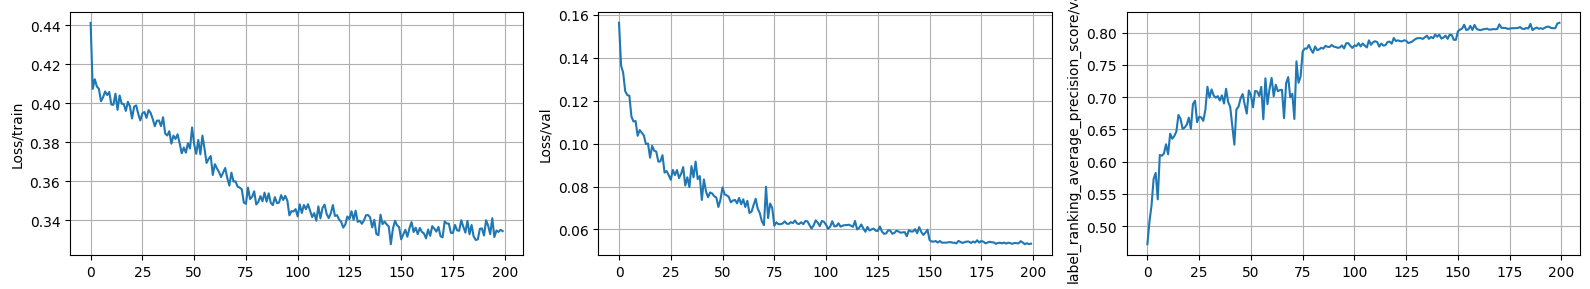

100%|██████████| 200/200 [2:30:26<00:00, 45.13s/it]


OutOfMemoryError: ignored

In [ ]:
train_and_save_model(IrResnet5, '100', name = 'v1.5.1')

# Оценка качества модели

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

35

In [ ]:
import torch

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cuda

Tesla T4
Memory Usage:
Allocated: 13.1 GB
Cached:    13.7 GB


/usr/local/lib/python3.10/dist-packages/torch/cuda/memory.py:416: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


# Конец